In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import models
import time
import glob
import PIL
import os
from PIL import Image

In [2]:
!ls drive/MyDrive/AI_DATASET/EuroSAT/EuroSAT

AnnualCrop  HerbaceousVegetation  Industrial  PermanentCrop  River
Forest	    Highway		  Pasture     Residential    SeaLake


In [3]:
DATA_PATH='drive/MyDrive/AI_DATASET/EuroSAT/EuroSAT/'

# Defining image transformations
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize((100,100)),
    # Normalize the image
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [4]:
# Defining hyperparameters
batch_size = 32
# num_epochs = 30
# learning_rate = 0.0003

In [5]:
data = datasets.ImageFolder(DATA_PATH, transform = transform) # Fetching dataset from folder

# train-test split
train_size = int(0.7 * len(data)) 
test_size = int(0.2 * len(data))
val_size = int(len(data) - (train_size+test_size))
train_dataset, test_dataset, val_dataset = random_split(data, [train_size, test_size, val_size])


print(f"Dataset has {len(data)} data points.")
print(f"Train Dataset has {len(train_dataset)} data points")
print(f"Test Dataset has {len(test_dataset)} data points.") 
print(f"Validation Dataset has {len(val_dataset)} data points.") 

Dataset has 25020 data points.
Train Dataset has 17514 data points
Test Dataset has 5004 data points.
Validation Dataset has 2502 data points.


In [6]:
train_loader = DataLoader(train_dataset, batch_size= batch_size, num_workers=2, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size= batch_size, num_workers=2, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size= batch_size, num_workers=2, shuffle= True)

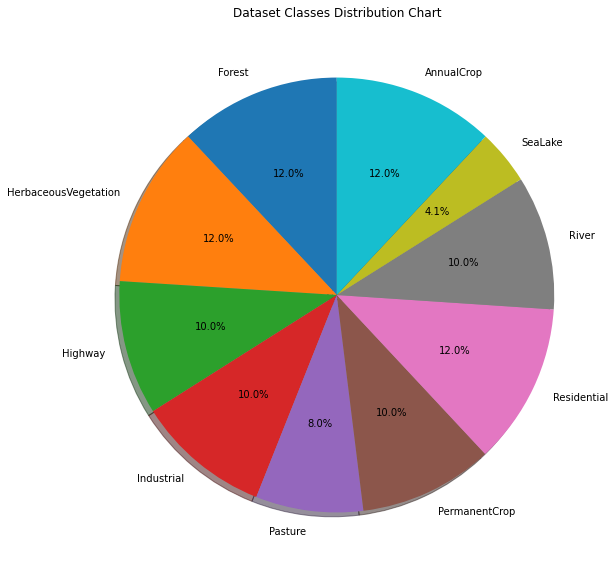

{'Forest': 2999, 'HerbaceousVegetation': 2999, 'Highway': 2499, 'Industrial': 2499, 'Pasture': 1999, 'PermanentCrop': 2499, 'Residential': 2999, 'River': 2499, 'SeaLake': 1019, 'AnnualCrop': 2999}


In [7]:
# Visualizing data distrubitons accordin to classes
class_names_train = os.listdir(DATA_PATH)

image_count = {}
for i in class_names_train:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH,i))) - 1

    
# Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        textprops=dict(color="black"),
        autopct = '%1.1f%%',
        startangle=90)
plt.title("Dataset Classes Distribution Chart", color='black')
plt.show()
print(image_count)

In [8]:
# Defining Model
model = models.resnet18();

for param in model.parameters():
    param.require_grad = False
    
fc = nn.Sequential(
    nn.AdaptiveMaxPool2d(1), 
    nn.Flatten(), 
    nn.Dropout(0.2),
    nn.Linear(512, 5)
)

model.classifier = fc
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Device: cuda:0


In [9]:
def train(model, train_loader, optimizer, num_epochs):   
    total_steps = len(train_loader)
    t1 = time.time()
    train_accuracy = []
    val_accuracy = []
    training_loss = []
    epoch_accuracy = 0
    total_label_i = 0
    validation_loss=[]


    for epoch in range(num_epochs):
        epoch_loss = 0
        correct_v=0 
        correct=0 
        total_v=0 
        total=0
        train_loss =0.0 
        print(epoch)
        for i, data in enumerate(train_loader):
            images, labels = data[0].to(device), data[1].to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backprop and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Train accuracy
            total += labels.size(0)
            _,predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            train_loss += loss.item() 

            total_label_i += total
            epoch_accuracy += (predicted == labels).float().sum()

        valid_loss=0.0;
        for i_v, data_v in enumerate(val_loader):
            images_v, labels_v = data[0].to(device), data[1].to(device)
            # Forward pass
            outputs_v = model(images_v)
            loss_v = criterion(outputs_v, labels_v)
            total_v += labels_v.size(0)
            _,predicted_v = torch.max(outputs_v.data, 1)
            correct_v += (predicted_v == labels_v).sum().item()
            valid_loss += loss_v.item()

        train_accuracy.append(round((correct/total)*100, 2))
        val_accuracy.append(round((correct_v/total_v)*100, 2))
        training_loss.append(train_loss/len(train_loader))
        validation_loss.append(valid_loss/len(val_loader))

        print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%'
            .format(epoch + 1, num_epochs, (train_loss/len(train_loader)), (valid_loss/len(val_loader)), (correct / total) * 100, 
              (correct_v / total_v) * 100))

    print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
    
    return train_accuracy, training_loss

In [10]:
# Training for Learning rate: 0.01
train_loader = DataLoader(train_dataset, batch_size= batch_size, num_workers=2, shuffle= True)
model = models.resnet18()

for param in model.parameters():
    param.require_grad = False
    
fc = nn.Sequential(
    nn.AdaptiveMaxPool2d(1), 
    nn.Flatten(), 
    nn.Dropout(0.2),
    nn.Linear(512, 5)
)

model.classifier = fc
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs=10

train_accuracy_lr_1, training_loss_1 = train(model, train_loader, optimizer, num_epochs)


Device: cuda:0
0
Epoch [1/10], Training Loss: 1.3934, Validation Loss: 1.2625, Training Accuracy: 51.69%, Validation Accuracy: 50.00%
1
Epoch [2/10], Training Loss: 0.8864, Validation Loss: 0.7097, Training Accuracy: 67.94%, Validation Accuracy: 70.00%
2
Epoch [3/10], Training Loss: 0.7312, Validation Loss: 0.4857, Training Accuracy: 73.52%, Validation Accuracy: 80.00%
3
Epoch [4/10], Training Loss: 0.6227, Validation Loss: 0.6713, Training Accuracy: 77.81%, Validation Accuracy: 90.00%
4
Epoch [5/10], Training Loss: 0.5278, Validation Loss: 0.5026, Training Accuracy: 81.33%, Validation Accuracy: 70.00%
5
Epoch [6/10], Training Loss: 0.4501, Validation Loss: 0.0783, Training Accuracy: 84.06%, Validation Accuracy: 100.00%
6
Epoch [7/10], Training Loss: 0.3978, Validation Loss: 0.3000, Training Accuracy: 86.29%, Validation Accuracy: 90.00%
7
Epoch [8/10], Training Loss: 0.3588, Validation Loss: 0.2246, Training Accuracy: 87.42%, Validation Accuracy: 90.00%
8
Epoch [9/10], Training Loss: 0

In [11]:
# Training for Learning rate: 0.001
train_loader = DataLoader(train_dataset, batch_size= batch_size, num_workers=2, shuffle= True)
model = models.resnet18()

for param in model.parameters():
    param.require_grad = False
    
fc = nn.Sequential(
    nn.AdaptiveMaxPool2d(1), 
    nn.Flatten(), 
    nn.Dropout(0.2),
    nn.Linear(512, 5)
)

model.classifier = fc
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs=10

train_accuracy_lr_2, training_loss_2 = train(model, train_loader, optimizer, num_epochs) 

Device: cuda:0
0
Epoch [1/10], Training Loss: 1.1207, Validation Loss: 0.8421, Training Accuracy: 61.37%, Validation Accuracy: 70.00%
1
Epoch [2/10], Training Loss: 0.7546, Validation Loss: 0.2118, Training Accuracy: 73.44%, Validation Accuracy: 100.00%
2
Epoch [3/10], Training Loss: 0.5968, Validation Loss: 0.2369, Training Accuracy: 79.07%, Validation Accuracy: 100.00%
3
Epoch [4/10], Training Loss: 0.4808, Validation Loss: 0.1654, Training Accuracy: 83.37%, Validation Accuracy: 90.00%
4
Epoch [5/10], Training Loss: 0.3914, Validation Loss: 0.1226, Training Accuracy: 86.35%, Validation Accuracy: 100.00%
5
Epoch [6/10], Training Loss: 0.3344, Validation Loss: 0.1654, Training Accuracy: 88.35%, Validation Accuracy: 90.00%
6
Epoch [7/10], Training Loss: 0.2892, Validation Loss: 0.1711, Training Accuracy: 89.92%, Validation Accuracy: 90.00%
7
Epoch [8/10], Training Loss: 0.2579, Validation Loss: 0.1119, Training Accuracy: 91.02%, Validation Accuracy: 100.00%
8
Epoch [9/10], Training Loss

In [12]:
# Training for Learning rate: 0.0001
train_loader = DataLoader(train_dataset, batch_size= batch_size, num_workers=2, shuffle= True)
model = models.resnet18()

for param in model.parameters():
    param.require_grad = False
    
fc = nn.Sequential(
    nn.AdaptiveMaxPool2d(1), 
    nn.Flatten(), 
    nn.Dropout(0.2),
    nn.Linear(512, 5)
)

model.classifier = fc
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs=10

train_accuracy_lr_3, training_loss_3 = train(model, train_loader, optimizer, num_epochs) 

Device: cuda:0
0
Epoch [1/10], Training Loss: 1.0907, Validation Loss: 0.4053, Training Accuracy: 67.80%, Validation Accuracy: 90.00%
1
Epoch [2/10], Training Loss: 0.6003, Validation Loss: 0.4990, Training Accuracy: 79.18%, Validation Accuracy: 90.00%
2
Epoch [3/10], Training Loss: 0.4673, Validation Loss: 0.1487, Training Accuracy: 83.60%, Validation Accuracy: 100.00%
3
Epoch [4/10], Training Loss: 0.3961, Validation Loss: 1.6697, Training Accuracy: 86.18%, Validation Accuracy: 70.00%
4
Epoch [5/10], Training Loss: 0.3160, Validation Loss: 0.0811, Training Accuracy: 88.92%, Validation Accuracy: 100.00%
5
Epoch [6/10], Training Loss: 0.2727, Validation Loss: 0.5895, Training Accuracy: 90.36%, Validation Accuracy: 80.00%
6
Epoch [7/10], Training Loss: 0.2253, Validation Loss: 0.2415, Training Accuracy: 92.31%, Validation Accuracy: 90.00%
7
Epoch [8/10], Training Loss: 0.1965, Validation Loss: 0.0854, Training Accuracy: 93.13%, Validation Accuracy: 100.00%
8
Epoch [9/10], Training Loss:

In [13]:
# Training for batch size = 32
batch_size=32
train_loader = DataLoader(train_dataset, batch_size= batch_size, num_workers=2, shuffle= True)
model = models.resnet18()

for param in model.parameters():
    param.require_grad = False
    
fc = nn.Sequential(
    nn.AdaptiveMaxPool2d(1), 
    nn.Flatten(), 
    nn.Dropout(0.2),
    nn.Linear(512, 5)
)

model.classifier = fc
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
num_epochs=10

train_accuracy_batch_1, training_loss_batch_1 = train(model, train_loader, optimizer, num_epochs) 

Device: cuda:0
0
Epoch [1/10], Training Loss: 1.1975, Validation Loss: 1.3228, Training Accuracy: 58.36%, Validation Accuracy: 50.00%
1
Epoch [2/10], Training Loss: 0.8387, Validation Loss: 0.3379, Training Accuracy: 70.45%, Validation Accuracy: 90.00%
2
Epoch [3/10], Training Loss: 0.6892, Validation Loss: 0.5352, Training Accuracy: 76.12%, Validation Accuracy: 80.00%
3
Epoch [4/10], Training Loss: 0.5861, Validation Loss: 0.4880, Training Accuracy: 79.87%, Validation Accuracy: 80.00%
4
Epoch [5/10], Training Loss: 0.4993, Validation Loss: 0.0782, Training Accuracy: 82.68%, Validation Accuracy: 100.00%
5
Epoch [6/10], Training Loss: 0.4216, Validation Loss: 0.2487, Training Accuracy: 85.55%, Validation Accuracy: 90.00%
6
Epoch [7/10], Training Loss: 0.3705, Validation Loss: 0.1116, Training Accuracy: 87.04%, Validation Accuracy: 100.00%
7
Epoch [8/10], Training Loss: 0.3107, Validation Loss: 0.0361, Training Accuracy: 89.17%, Validation Accuracy: 100.00%
8
Epoch [9/10], Training Loss:

In [14]:
# Training for batch size = 64
batch_size=64
train_loader = DataLoader(train_dataset, batch_size= batch_size, num_workers=2, shuffle= True)
model = models.resnet18()

for param in model.parameters():
    param.require_grad = False
    
fc = nn.Sequential(
    nn.AdaptiveMaxPool2d(1), 
    nn.Flatten(), 
    nn.Dropout(0.2),
    nn.Linear(512, 5)
)

model.classifier = fc
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
num_epochs=10

train_accuracy_batch_2, training_loss_batch_2 = train(model, train_loader, optimizer, num_epochs) 

Device: cuda:0
0
Epoch [1/10], Training Loss: 1.2414, Validation Loss: 0.6889, Training Accuracy: 56.83%, Validation Accuracy: 73.81%
1
Epoch [2/10], Training Loss: 0.7885, Validation Loss: 0.4014, Training Accuracy: 71.73%, Validation Accuracy: 85.71%
2
Epoch [3/10], Training Loss: 0.6416, Validation Loss: 0.6298, Training Accuracy: 77.34%, Validation Accuracy: 78.57%
3
Epoch [4/10], Training Loss: 0.5596, Validation Loss: 0.6342, Training Accuracy: 80.76%, Validation Accuracy: 80.95%
4
Epoch [5/10], Training Loss: 0.4785, Validation Loss: 0.2590, Training Accuracy: 83.73%, Validation Accuracy: 95.24%
5
Epoch [6/10], Training Loss: 0.4352, Validation Loss: 0.2506, Training Accuracy: 84.89%, Validation Accuracy: 90.48%
6
Epoch [7/10], Training Loss: 0.3713, Validation Loss: 0.2373, Training Accuracy: 87.00%, Validation Accuracy: 95.24%
7
Epoch [8/10], Training Loss: 0.3336, Validation Loss: 0.2095, Training Accuracy: 88.49%, Validation Accuracy: 92.86%
8
Epoch [9/10], Training Loss: 0.

In [15]:
# Training for batch size = 128
batch_size=128
train_loader = DataLoader(train_dataset, batch_size= batch_size, num_workers=2, shuffle= True)
model = models.resnet18()

for param in model.parameters():
    param.require_grad = False
    
fc = nn.Sequential(
    nn.AdaptiveMaxPool2d(1), 
    nn.Flatten(), 
    nn.Dropout(0.2),
    nn.Linear(512, 5)
)

model.classifier = fc
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
num_epochs=10

train_accuracy_batch_3, training_loss_batch_3 = train(model, train_loader, optimizer, num_epochs) 

Device: cuda:0
0
Epoch [1/10], Training Loss: 1.2207, Validation Loss: 0.5955, Training Accuracy: 58.96%, Validation Accuracy: 77.36%
1
Epoch [2/10], Training Loss: 0.7895, Validation Loss: 0.4961, Training Accuracy: 71.88%, Validation Accuracy: 82.08%
2
Epoch [3/10], Training Loss: 0.6544, Validation Loss: 0.5497, Training Accuracy: 76.44%, Validation Accuracy: 81.13%
3
Epoch [4/10], Training Loss: 0.5787, Validation Loss: 0.4378, Training Accuracy: 79.70%, Validation Accuracy: 85.85%
4
Epoch [5/10], Training Loss: 0.5214, Validation Loss: 0.3891, Training Accuracy: 81.88%, Validation Accuracy: 86.79%
5
Epoch [6/10], Training Loss: 0.4535, Validation Loss: 0.3483, Training Accuracy: 84.31%, Validation Accuracy: 88.68%
6
Epoch [7/10], Training Loss: 0.3924, Validation Loss: 0.3649, Training Accuracy: 86.56%, Validation Accuracy: 88.68%
7
Epoch [8/10], Training Loss: 0.3613, Validation Loss: 0.3668, Training Accuracy: 87.59%, Validation Accuracy: 86.79%
8
Epoch [9/10], Training Loss: 0.

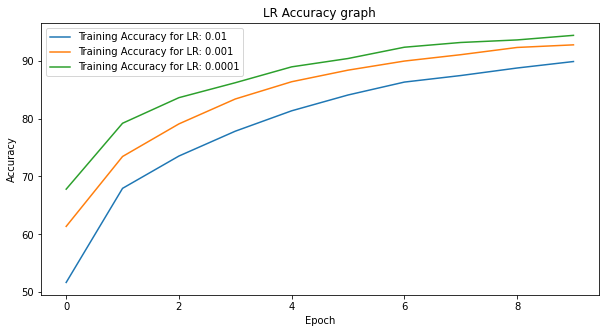

In [16]:
#Plotting Training accuracy for different learning rates:
epochs = [i for i in range(10)]
plt.figure(figsize=(10,5))
plt.title("LR Accuracy graph")
plt.plot(epochs, train_accuracy_lr_1, label="Training Accuracy for LR: 0.01")
plt.plot(epochs, train_accuracy_lr_2, label="Training Accuracy for LR: 0.001")
plt.plot(epochs, train_accuracy_lr_3, label="Training Accuracy for LR: 0.0001")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

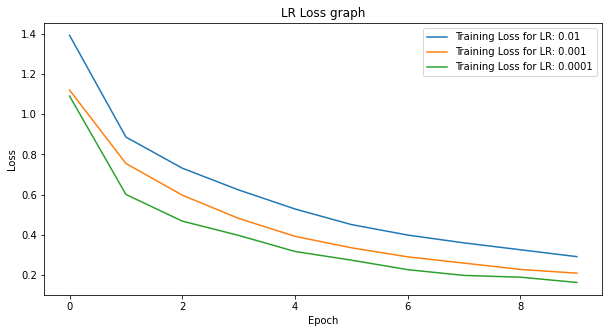

In [17]:
#Plotting Training loss for different learning rates:
epochs = [i for i in range(10)]
plt.figure(figsize=(10,5))
plt.title("LR Loss graph")
plt.plot(epochs, training_loss_1, label="Training Loss for LR: 0.01")
plt.plot(epochs, training_loss_2, label="Training Loss for LR: 0.001")
plt.plot(epochs, training_loss_3, label="Training Loss for LR: 0.0001")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

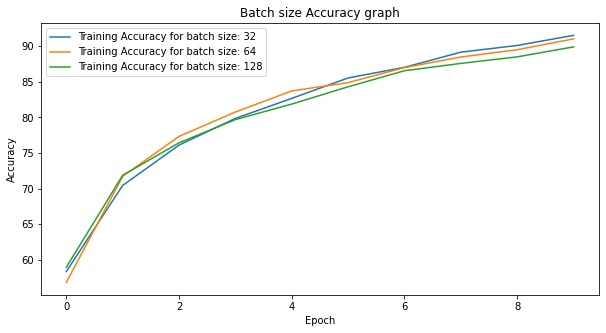

In [18]:
#Plotting Training accuracy for different batch size:
epochs = [i for i in range(10)]
plt.figure(figsize=(10,5))
plt.title("Batch size Accuracy graph")
plt.plot(epochs, train_accuracy_batch_1, label="Training Accuracy for batch size: 32")
plt.plot(epochs, train_accuracy_batch_2, label="Training Accuracy for batch size: 64")
plt.plot(epochs, train_accuracy_batch_3, label="Training Accuracy for batch size: 128")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()  

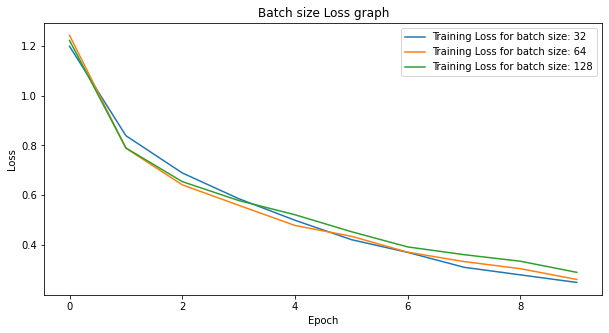

In [19]:
#Plotting Training loss for different batch size:
epochs = [i for i in range(10)]
plt.figure(figsize=(10,5))
plt.title("Batch size Loss graph")
plt.plot(epochs, training_loss_batch_1, label="Training Loss for batch size: 32")
plt.plot(epochs, training_loss_batch_2, label="Training Loss for batch size: 64")
plt.plot(epochs, training_loss_batch_3, label="Training Loss for batch size: 128")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
#TSNE
model.eval()
targets_list = []
outputs_list = []

with torch.no_grad():
    for idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        targets_np = targets.data.cpu().numpy()

        outputs = model(inputs)
        outputs_np = outputs.data.cpu().numpy()

        targets_list.append(targets_np[:, np.newaxis])
        outputs_list.append(outputs_np)

targets = np.concatenate(targets_list, axis=0)
outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

Generating t-SNE plot...


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


done!


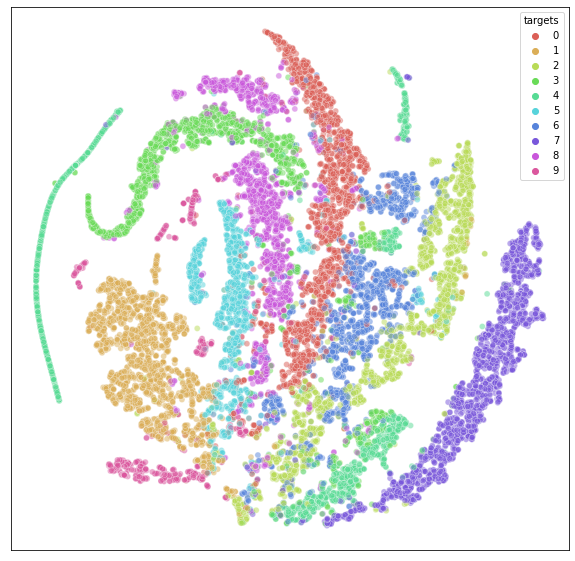

In [21]:
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
print('Generating t-SNE plot...')
# tsne_output = bh_sne(outputs)
tsne = TSNE(random_state=0)
tsne_output = tsne.fit_transform(outputs)

df = pd.DataFrame(tsne_output, columns=['x', 'y'])
df['targets'] = targets

plt.rcParams['figure.figsize'] = 10, 10
sns.scatterplot(
    x='x', y='y',
    hue='targets',
    palette=sns.color_palette("hls", 10),
    data=df,
    marker='o',
    legend="full",
    alpha=0.5
)

plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

# plt.savefig(os.path.join(save_dir,'tsne.png'), bbox_inches='tight')
print('done!')

In [22]:
# Calculating Test Accuracy
model.eval() 

with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

Test Accuracy of the model on the 5004 test images: 88.56914468425259 %


In [25]:
pip install python-igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 29.6 MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.10.2-py3-none-any.whl size=9074 sha256=34aeb60629d68ea0ebe34bbd90e7fec53a975854a47654eab025acd78a9b52e3
  Stored in directory: /root/.cache/pip/wheels/47/93/11/c7c992fab551e7a7fa504097aac4b992dac996aa1c81490afb
Successfully built python-igraph


In [26]:
#T-SNE For EuroSAT

import random
import numpy as np
import pickle
from PIL import Image
from scipy.spatial import distance
import igraph
import cv2
import os
from skimage import io
from sklearn.feature_extraction import image 
from sklearn.manifold import TSNE
from tqdm import tqdm
%matplotlib inline

In [27]:
data = []
folder = 'drive/MyDrive/AI_DATASET/EuroSAT/EuroSAT/'
fold=['AnnualCrop/','Industrial/','River/','Forest/','Pasture/','SeaLake/','HerbaceousVegetation/','PermanentCrop/','Highway/','Residential/']
for f in fold:
    for filename in tqdm((os.listdir(folder+f))):
        image = cv2.imread(os.path.join(folder+f,filename))
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (45,45))
            image = image.flatten()
            data.append([image, folder+f+ filename])

100%|██████████| 3000/3000 [00:08<00:00, 358.02it/s]


In [28]:
from sklearn.decomposition import PCA
features, images  = zip(*data)

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

num_images_to_plot = len(images)

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [29]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=350, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25020 samples in 0.005s...
[t-SNE] Computed neighbors for 25020 samples in 18.404s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25020
[t-SNE] Computed conditional probabilities for sample 2000 / 25020
[t-SNE] Computed conditional probabilities for sample 3000 / 25020
[t-SNE] Computed conditional probabilities for sample 4000 / 25020
[t-SNE] Computed conditional probabilities for sample 5000 / 25020
[t-SNE] Computed conditional probabilities for sample 6000 / 25020
[t-SNE] Computed conditional probabilities for sample 7000 / 25020
[t-SNE] Computed conditional probabilities for sample 8000 / 25020
[t-SNE] Computed conditional probabilities for sample 9000 / 25020
[t-SNE] Computed conditional probabilities for sample 10000 / 25020
[t-SNE] Computed conditional probabilities for sample 11000 / 25020
[t-SNE] Computed conditional probabilities for sample 12000 / 25020
[t-SNE] Computed conditional probabilities for sa

In [30]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

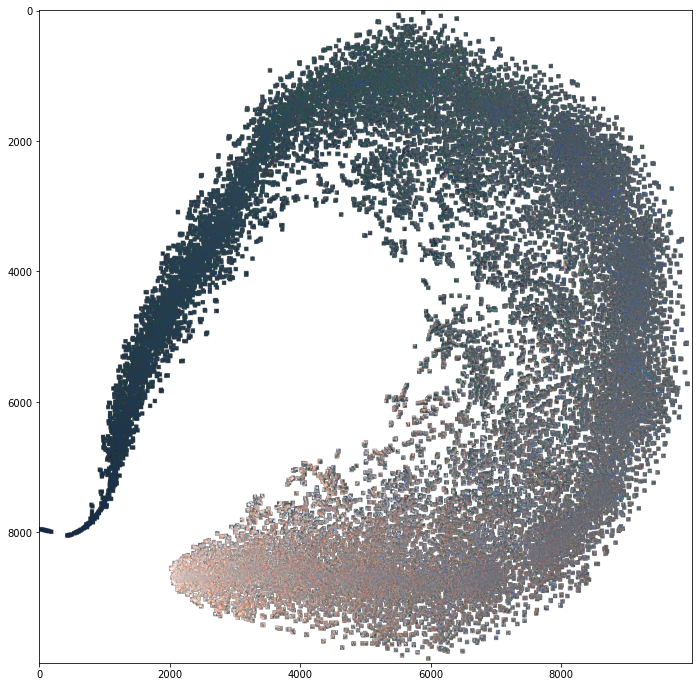

In [31]:
import matplotlib.pyplot
from matplotlib.pyplot import imshow

width = 10000
height = 10000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)